In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('dark_background')
from patsy import dmatrices


Date            object
Vibration      float64
Temperature    float64
IR             float64
IY             float64
IB             float64
VR             float64
VY             float64
VB             float64
dtype: object
Date           datetime64[ns]
Vibration             float64
Temperature           float64
IR                    float64
IY                    float64
IB                    float64
VR                    float64
VY                    float64
VB                    float64
dtype: object


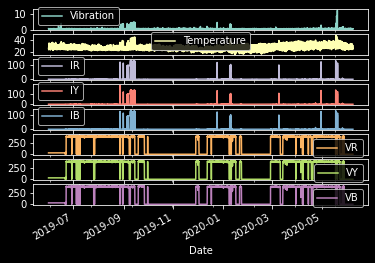

In [3]:

# Load the data set 
df = pd.read_csv(r"C:\Smita Mahajan\PhD\ML_DL\NW\hsdpump.csv")
print(df.dtypes)
df['Date']= pd.to_datetime(df['Date'])
print(df.dtypes)
df.set_index('Date', inplace= True)
df.plot(subplots=True)
import statsmodels.api as sm

In [4]:

from fireTS.models import NARX, DirectAutoRegressor
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
#%matplotlib notebook
df = df[df.Vibration.isnull() == False]
df.head()
df.shape
df.isna().sum()

C:\Users\mahaj\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Vibration      0
Temperature    0
IR             0
IY             0
IB             0
VR             0
VY             0
VB             0
dtype: int64

In [5]:
ytrain = df['Vibration'].iloc[:1000]
Xtrain = df.loc[:, ['IR', 'IY','IB']].iloc[:1000, :]

ytest = df['Vibration'].iloc[1000:-1]
Xtest = df.loc[:, ['IR', 'IY','IB']].iloc[1000:-1, :]

In [6]:

df['Year']=[d.year for d in df.index]
df['MONTH'] = df.index.month
df['Month']= [d.month for d in df.index]
df['Day'] = [d.day for d in df.index]
df['Time']=[d.hour for d in df.index]


<AxesSubplot:xlabel='Month', ylabel='Vibration'>

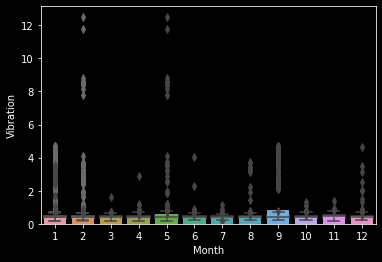

In [7]:

sns.boxplot(x='Year', y= 'Vibration', data = df)
sns.boxplot(x='Month', y= 'Vibration', data = df)

sns.barplot(x='Year', y= 'Vibration', data = df)
sns.barplot(x='Month', y= 'Vibration', data = df)


In [8]:

#Create the training and testing data sets.
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=7155
Testing data set length=1819


In [9]:


#Setup the regression expression in patsy notation. We are telling patsy that Vibratiob is our dependent variable and
# it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP.
expr = """Vibration ~ Temperature  + IR + IB + IY + VR + VB + VY """



In [10]:

#Set up the X and y matrices
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')


In [11]:


#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [12]:

#Print the training summary.
print(poisson_training_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Vibration   No. Observations:                 7155
Model:                            GLM   Df Residuals:                     7147
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5093.2
Date:                Sun, 16 May 2021   Deviance:                       449.18
Time:                        23:18:35   Pearson chi2:                     893.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.2859      0.111    -11.554      

In [13]:

#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                         mean   mean_se  mean_ci_lower  mean_ci_upper
Date                                                                 
2019-06-01 07:00:00  0.426432  0.011320       0.404813       0.449206
2019-06-01 09:00:00  0.446168  0.011400       0.424376       0.469080
2019-06-01 13:00:00  0.496914  0.018723       0.461539       0.535000
2019-06-02 03:00:00  0.445208  0.011353       0.423504       0.468025
2019-06-02 06:00:00  0.436659  0.011132       0.415377       0.459031
...                       ...       ...            ...            ...
2020-06-07 01:16:00  0.427995  0.011996       0.405119       0.452164
2020-06-07 19:16:00  0.470552  0.014920       0.442200       0.500722
2020-06-07 20:16:00  0.462512  0.013822       0.436199       0.490412
2020-06-07 23:16:00  0.444919  0.012250       0.421546       0.469588
2020-06-08 05:16:00  0.426155  0.012043       0.403193       0.450425

[1819 rows x 4 columns]


In [14]:

poisson_predictions = poisson_training_results.get_prediction(X_test)

In [15]:

#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['Vibration']


                         mean   mean_se  mean_ci_lower  mean_ci_upper
Date                                                                 
2019-06-01 07:00:00  0.426432  0.011320       0.404813       0.449206
2019-06-01 09:00:00  0.446168  0.011400       0.424376       0.469080
2019-06-01 13:00:00  0.496914  0.018723       0.461539       0.535000
2019-06-02 03:00:00  0.445208  0.011353       0.423504       0.468025
2019-06-02 06:00:00  0.436659  0.011132       0.415377       0.459031
...                       ...       ...            ...            ...
2020-06-07 01:16:00  0.427995  0.011996       0.405119       0.452164
2020-06-07 19:16:00  0.470552  0.014920       0.442200       0.500722
2020-06-07 20:16:00  0.462512  0.013822       0.436199       0.490412
2020-06-07 23:16:00  0.444919  0.012250       0.421546       0.469588
2020-06-08 05:16:00  0.426155  0.012043       0.403193       0.450425

[1819 rows x 4 columns]


In [16]:


model = sm.OLS(y_train, X_train, family=sm.families.Poisson()).fit()


#results = model.fit()
results_summary = model.summary()

                            OLS Regression Results                            
Dep. Variable:              Vibration   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     1772.
Date:                Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                        23:19:52   Log-Likelihood:                -1951.1
No. Observations:                7155   AIC:                             3918.
Df Residuals:                    7147   BIC:                             3973.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2269      0.025      9.126      

TypeError: float() argument must be a string or a number, not 'RegressionResultsWrapper'

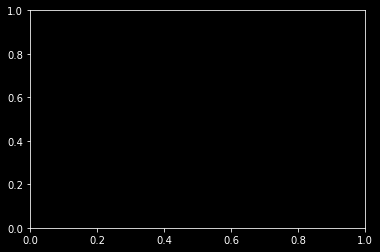

In [17]:

results_as_html = results_summary.tables[1].as_html()
pd.read_html(results_as_html, header=0, index_col=0)[0]
print (results_summary)
plt.plot(model)

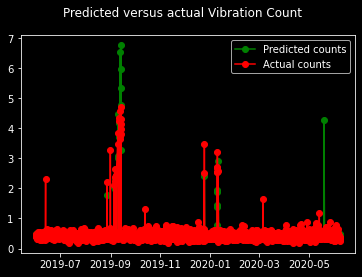

In [18]:


#Mlot the predicted counts versus the actual counts for the test data.
fig = plt.figure()
fig.suptitle('Predicted versus actual Vibration Count')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

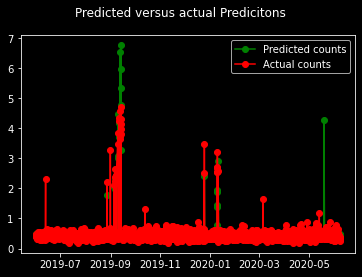

In [19]:

predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['Vibration']
fig = plt.figure()
fig.suptitle('Predicted versus actual Predicitons ')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

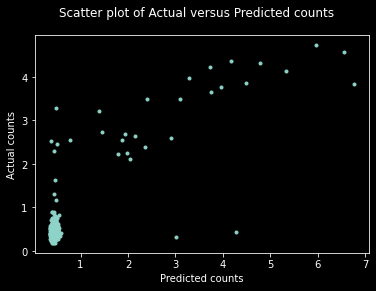

In [20]:

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()
